<a href="https://colab.research.google.com/github/ArtuomMerkulov/-Goods-Forecast.OSA-1-/blob/main/finaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn import metrics

In [ ]:
train = pd.read_csv(r'D:\programms\python\хакатоны\OSA\data\train.csv')
test = pd.read_csv(r'D:\programms\python\хакатоны\OSA\data\test.csv')

C:\Users\admin\AppData\Local\Temp\ipykernel_4148\1112592523.py:1: DtypeWarning: Columns (44,46) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(r'D:\programms\python\хакатоны\OSA\data\train.csv')


In [ ]:
train['ValidationDateTime'] = pd.to_datetime(train['ValidationDateTime'])
test['ValidationDateTime'] = pd.to_datetime(test['ValidationDateTime'])

внутренняя модель для отравки сообщений на проверку товара изменилась с 11 июля, поэтому данные до этой даты не релевантны

In [ ]:
train = train[((train['ValidationDateTime'].dt.month==7)&(train['ValidationDateTime'].dt.day>10))].reset_index(drop=True)

delete_col - признаки для удаления. Они либо сильно коррелируют с другими признаками, либо являются константой
cat_col - категориальные признаки
cat_nan - Признаки которые содержат пропущенные значения(Nan) и эти пропущенные значения имеют статистическую значимость в распределении целевой переменой(Тесты проводились по Хи - квадрату и Т тесту)

In [ ]:
delete_col =  ['Column9', 'Column10', 'Column26', 'Column58', 'Column59','Column60', 'Column61','Column62', 'Column63', 'Column64', 'Column65', 'Column66', 'Column67', 'Column54', 'Column55', 'Column56', 'Column57']

cat_col = ['LocationId', 'ProductId', 'Column12', 'Column18', 'Column19', 'Column24', 'Column25', 'Column47', 'Column49', 'Column52']

cat_nan = ["Column8", "Column16", "Column17", "Column20", "Column22",
"Column23", "Column27", "Column28", "Column29", "Column40", "Column41", "Column43", "Column44"]

Удаляем признак Probability(1 трек)

In [ ]:
train.drop('Probability', axis = 1, inplace=True)
test.drop('Probability', axis = 1, inplace=True)

In [ ]:
train.drop(columns=delete_col, inplace=True)
test.drop(columns=delete_col, inplace=True)

Так как Nanы значимы, сохраним информацию о них в бинарных признаках

In [ ]:
for col in cat_nan:
    train[f'{col}_na'] = train[col].isna()
    test[f'{col}_na'] = test[col].isna()

In [ ]:
col_is_na = train.columns[train.isna().sum()>0]
col_not_na = train.columns[train.isna().sum()==0]

Заполняем промущенные значения

In [ ]:
ct = ColumnTransformer(
    [
        ('nan_cat', SimpleImputer(strategy='most_frequent'), list(set(col_is_na) & set(cat_col))),
        ('nan_no_cat', KNNImputer(), col_is_na.difference(cat_col))
    ]
)
t = pd.DataFrame(ct.fit_transform(train), columns=col_is_na)
train = pd.concat([t, train[col_not_na]], axis = 1)
t2 = pd.DataFrame(ct.transform(test), columns=col_is_na)
test = pd.concat([t2, test[test.columns.difference(col_is_na)]], axis = 1)

In [ ]:
def get_time(df_):
    df = df_['ValidationDateTime']
    day = df.dt.day
    day_week = df.dt.day_of_week
    hour = df.dt.hour
    df_['sin_hour'] = np.sin(2*np.pi*hour/24)
    df_['cos_hour'] = np.cos(2*np.pi*hour/24)
    df_['sin_day_week'] = np.sin(2*np.pi*day_week/6)
    df_['cos_day_week'] = np.cos(2*np.pi*day_week/6)
    df_['sin_day'] = np.sin(2*np.pi*day/31)
    df_['cos_day'] = np.cos(2*np.pi*day/31)
    return df_.drop('ValidationDateTime', axis = 1)

Циклически кодируем дату и время

In [ ]:
val_time_train = train['ValidationDateTime']
val_time_test = test['ValidationDateTime']
train = get_time(train)
test = get_time(test)

In [ ]:
train = train.astype('float')
test = test.astype('float')
train[cat_col + ['IsCorrect']] = train[cat_col + ['IsCorrect']].astype('int')
test[cat_col] = test[cat_col].astype('int')

In [ ]:
from catboost import Pool, cv, CatBoostClassifier, CatBoost
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
target = train['IsCorrect']
test.drop('IsCorrect', inplace=True, axis= 1)
train = train.drop('IsCorrect', axis = 1)

In [ ]:
pool = Pool(data = train, label=target, cat_features=cat_col)
params = {
    'loss_function': 'Logloss',
    'custom_loss': ['AUC', 'BalancedAccuracy'],
    'learning_rate': 0.04,
    'verbose':False,
    'n_estimators':1500,
    'max_depth':2,
    'l2_leaf_reg':60,
    'random_strength': 12.558038857085643
}
cv_ = cv(pool, params=params, plot=True, folds=TimeSeriesSplit(5))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.489951503
bestIteration = 148

Training on fold [1/5]

bestTest = 0.4769265381
bestIteration = 1494

Training on fold [2/5]

bestTest = 0.4763469017
bestIteration = 171

Training on fold [3/5]

bestTest = 0.4704305654
bestIteration = 719

Training on fold [4/5]

bestTest = 0.4118155228
bestIteration = 1262



In [ ]:
print("Кроссвалидация при folds = 5: ROC-AUC", cv_['test-AUC-mean'].iloc[-1])

Кроссвалидация при folds = 5: ROC-AUC 0.8637816346713754


In [ ]:
x_train = train.iloc[:]
x_test = train.iloc[:]
y_train = target.iloc[:]
y_test = target.iloc[:]

In [ ]:
cat_model = CatBoostClassifier(**params)
tpool = Pool(x_train, y_train, cat_features=cat_col)
vpool = Pool(x_test, y_test, cat_features=cat_col)
cat_model.fit(tpool, eval_set=(vpool), plot=True, use_best_model = False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
pred_train = cat_model.predict(x_train)
pred_test = cat_model.predict(x_test)

In [ ]:
print(metrics.classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       0.82      0.92      0.86      7242
           1       0.91      0.80      0.85      7587

    accuracy                           0.86     14829
   macro avg       0.86      0.86      0.86     14829
weighted avg       0.87      0.86      0.86     14829



In [ ]:
print(metrics.classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.73      0.81      0.77     11980
           1       0.80      0.72      0.76     12955

    accuracy                           0.76     24935
   macro avg       0.77      0.77      0.76     24935
weighted avg       0.77      0.76      0.76     24935



In [ ]:
print("Train", metrics.roc_auc_score(y_train, cat_model.predict_proba(x_train)[:,1]))
print("Test", metrics.roc_auc_score(y_test, cat_model.predict_proba(vpool)[:,1]))

Train 0.9357897254955834
Test 0.8413071702548116


In [ ]:
coef = pd.DataFrame(cat_model.feature_importances_, index=x_train.columns).sort_values(0)

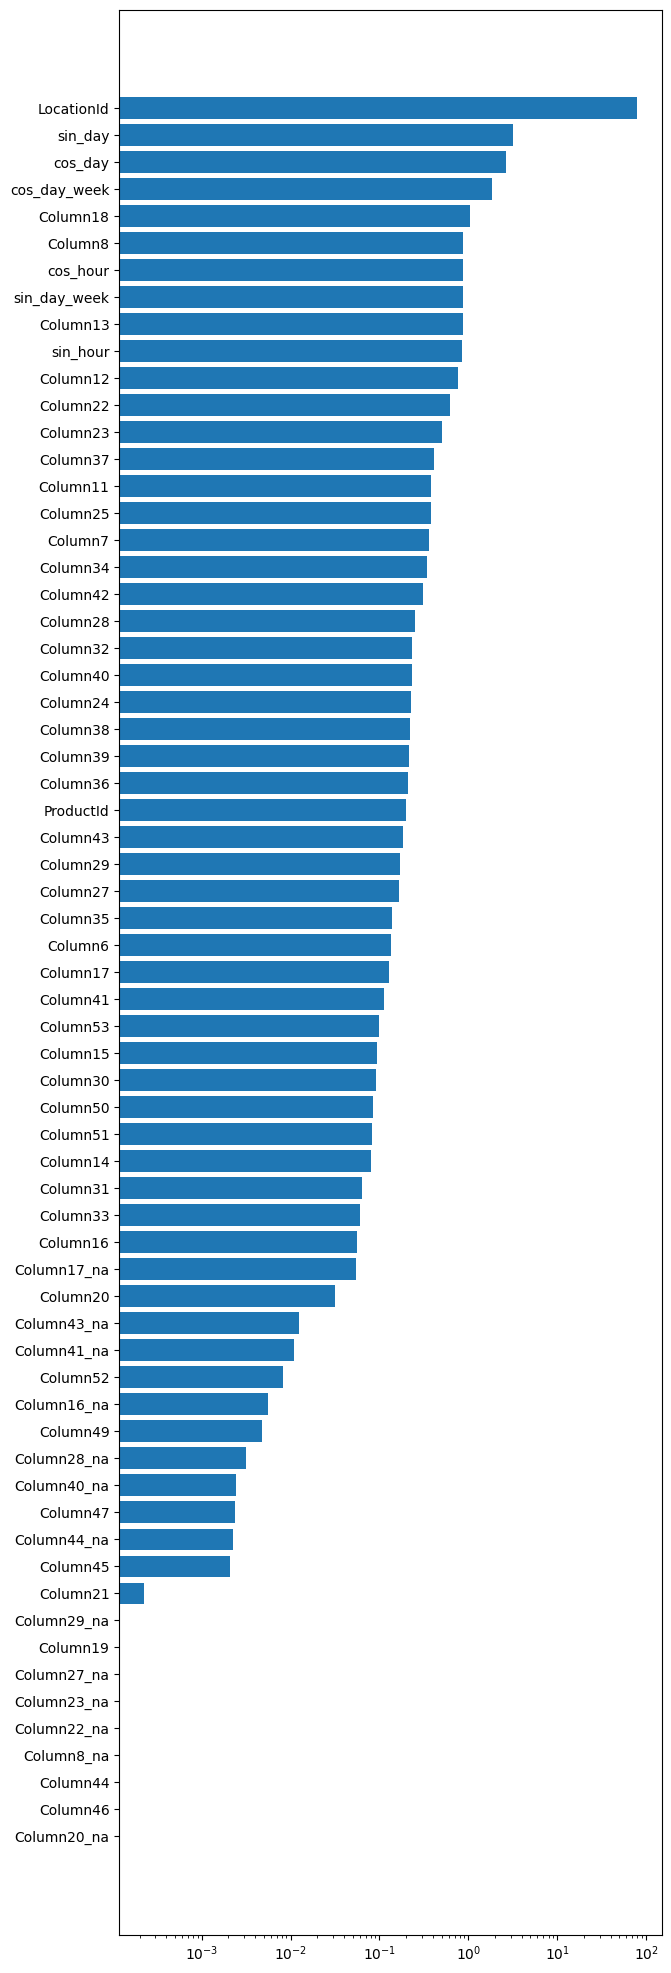

In [ ]:
plt.figure(figsize=(7, 25))
plt.barh(y = coef.index, width=coef[0])
plt.xscale('log')

In [ ]:
sampl_pred = pd.DataFrame()
sampl_pred['LocationId'] = x_test['LocationId']
sampl_pred['ProductId'] = x_test['ProductId']
sampl_pred['ValidationDateTime'] = val_time_train.loc[x_test.index]
sampl_pred['CalculatedProbability'] = cat_model.predict_proba(x_test)[:,1]
sampl_pred.to_csv('output/XackOSA_1.csv', index=False, sep=';')

OSError: Cannot save file into a non-existent directory: 'output'

In [ ]:
train['time'] = val_time_train

In [ ]:
(sampl_pred['CalculatedProbability']>0.5).astype('int')

14829    0
14830    0
14831    1
14832    1
14833    1
        ..
39759    0
39760    1
39761    0
39762    0
39763    1
Name: CalculatedProbability, Length: 24935, dtype: int32

In [ ]:
t

IsCorrect,week,0,1,All
0,0,10185,11462,21647
1,1,9037,9080,18117
2,All,19222,20542,39764


In [ ]:
t = pd.crosstab(train['time'].dt.minute, target, margins=True).reset_index()
x = t['time'].iloc[:-1]
y = t[1].iloc[:-1]/t['All'].iloc[:-1]
t2 = pd.crosstab(sampl_pred['ValidationDateTime'].dt.minute, (sampl_pred['CalculatedProbability']>0.5).astype('int'), margins=True).reset_index()
x2 = t2['ValidationDateTime'].iloc[:-1]
y2 = t2[1].iloc[:-1]/t2['All'].iloc[:-1]
t3 = pd.crosstab(train['time'].iloc[-24935:].dt.minute, y_test, margins=True).reset_index()
x3 = t3['time'].iloc[:-1]
y3 = t3[1].iloc[:-1]/t3['All'].iloc[:-1]

In [ ]:
x.iloc[np.argsort(y).values[:-10:-1]].values

array([57, 56, 59, 4, 58, 2, 3, 0, 1], dtype=object)

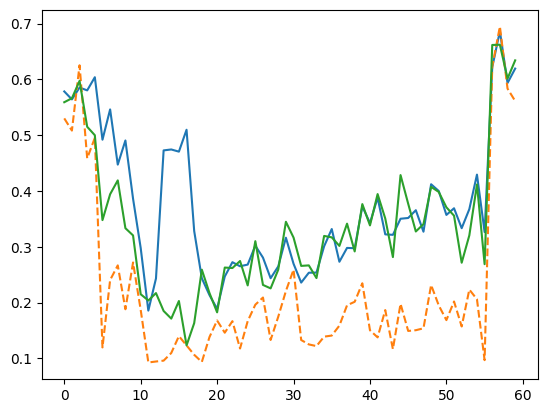

In [ ]:
plt.plot(x ,y)
plt.plot(x2 ,y2, '--')
plt.plot(x3 ,y3)

(array([ 5036.,  4801.,  3857.,  3484.,  2473.,  1883.,  1831.,  1657.,
         2970., 12779.]),
 array([0.01319363, 0.11156272, 0.20993181, 0.30830091, 0.40667   ,
        0.50503909, 0.60340819, 0.70177728, 0.80014637, 0.89851547,
        0.99688456]),
 <BarContainer object of 10 artists>)

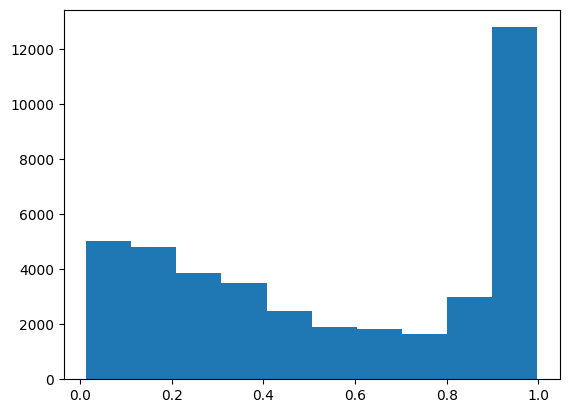

In [ ]:
plt.hist(cat_model.predict_proba(test[x_train.columns])[:,1])